In [1]:
import torch  
from tqdm.autonotebook import tqdm
from datasets_tools import load_dataset, create_splits
from datasets_tools import get_occupation_labels, load_embeddings
from model_utils import get_model

/var/folders/z7/zxmjm5fs0gg5rjdp2rjzm4kw0000gn/T/ipykernel_10965/929152306.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
baseline = 'normal' 
#baseline = 'nogender'

#modeltype, nb_epochs = 'RoBERTa', 10
#modeltype, nb_epochs = 'DeBERTa', 3
modeltype, nb_epochs = 'DistilBERT', 3


datafolder = "/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/data"
if baseline == "normal":
  model_path = f"/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/{modeltype}_occBIOS_{nb_epochs}epochs_g1"  # predict occ
elif baseline == 'nogender':
  model_path = f"/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/{modeltype}_occBIOS_{nb_epochs}epochs_ng1"  # predict occ

else:
  print("Baseline not found")

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dt_X, gender_names, occ_names = load_dataset(datafolder, baseline=baseline)
splits, genders = create_splits(dt_X)
model, tokenizer = get_model(model_path, model_type = modeltype)
dt_X_train, dt_X_val, dt_X_test = splits
gender_train, gender_val, gender_test = genders

In [4]:
dt_X

,sentence,gender,label
0,She is also a Ronald D. Asmus Policy Entrepre...,0,3
1,He is a member of the AICPA and WICPA. Brent ...,1,23
2,Dr Aster has held teaching and research posit...,1,3
3,She currently works on CNN’s newest primetime...,0,12
4,He runs a boutique design studio attending cl...,1,13
...,...,...,...
388857,Fernando focuses his practice in all forms of...,1,14
388858,He maintains the trade policy site url. Rajan...,1,3
388859,"She teaches courses in Technical Writing, Com...",0,3
388860,He has been responsible for many facets of fi...,1,23


In [6]:
from utils import batch_predict

ntest = 50
features_ntest, labels_ntest = batch_predict(model.features, tokenizer, dt_X_test[:ntest], 32, device)
ypred_bis_ntest = model.end_model(features_ntest)

ypred_ntest, labels_ntest = batch_predict(model.forward, tokenizer, dt_X_test[:ntest], 32, device)

print("accuracy for classic model:", torch.mean((torch.argmax(ypred_ntest, -1) == labels_ntest).float()))
print("accuracy for model in 'two parts':", torch.mean((torch.argmax(ypred_bis_ntest, -1) == labels_ntest).float()))

100%|██████████| 2/2 [00:06<00:00,  3.20s/it]

accuracy for classic model: tensor(0.8600)
accuracy for model in 'two parts': tensor(0.8400)


In [5]:
datasets = dt_X_train, dt_X_val, dt_X_test
train_val_test_features, train_val_test_labels = load_embeddings(datasets,
                                                                 model=model,
                                                                 tokenizer=tokenizer,
                                                                 baseline=baseline,
                                                                 regenerate=False,
                                                                 model_type=modeltype,
                                                                 device=device)
train_features, val_features, test_features = train_val_test_features
train_labels, val_labels, test_labels = train_val_test_labels


train_labels, val_labels, test_labels = get_occupation_labels(dt_X_train, dt_X_val, dt_X_test, device)

In [6]:
ypred_test = model.end_model(test_features)
print("accuracy for classic model:", torch.mean((torch.argmax(ypred_test, -1) == test_labels).float()))

accuracy for classic model: tensor(0.8616)


In [95]:
train_features, train_features.shape

(tensor([[ 0.8497, -0.7409, -0.6220,  ..., -0.9276,  0.6046,  0.5081],
         [-0.4725,  0.0533, -0.5539,  ..., -0.0038, -1.4755,  0.1829],
         [-1.2480,  0.1682, -1.0883,  ...,  0.5235, -0.0657,  1.2301],
         ...,
         [ 0.7502, -0.7445, -0.5568,  ..., -1.1008,  0.5447,  0.5428],
         [-1.3762,  0.0918, -0.4574,  ..., -0.1524, -0.1649,  0.0748],
         [ 0.1080, -0.9622, -0.4966,  ...,  0.4012, -0.7115, -0.6903]]),
 torch.Size([272203, 768]))

In [96]:
val_features.shape, test_features.shape

(torch.Size([38886, 768]), torch.Size([77773, 768]))

In [97]:
train_labels.shape, val_labels.shape, test_labels.shape

(torch.Size([272203]), torch.Size([38886]), torch.Size([77773]))

In [98]:
gender_train.shape, gender_val.shape, gender_test.shape

((272203,), (38886,), (77773,))

# Train Model to predict gender

In [7]:
from train import train_genders
from train import LogisticMLP


retrain_gender_model = False
mlp_or_lin = 'mlp'
real_dataset = (train_features, val_features, test_features)
save_name = f'gender_pred/{modeltype}_{mlp_or_lin}_baseline_{baseline}.pt'
if retrain_gender_model:
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=200,
                          train_on_validation_set=True,
                          model_type=mlp_or_lin,
                          save_path_and_name=save_name)
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_features.shape[1]
  state_dict = torch.load(save_name, map_location=torch.device(device))
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=0,
                          train_on_validation_set=True,
                          model_type=mlp_or_lin,
                          state_dict=state_dict)

Final evaluation on the test set:

Val set: Average loss: 0.0759, Accuracy: 76517/77773 (98.385%)


Train to predict gender from occupation

Accuracy: 62.679%


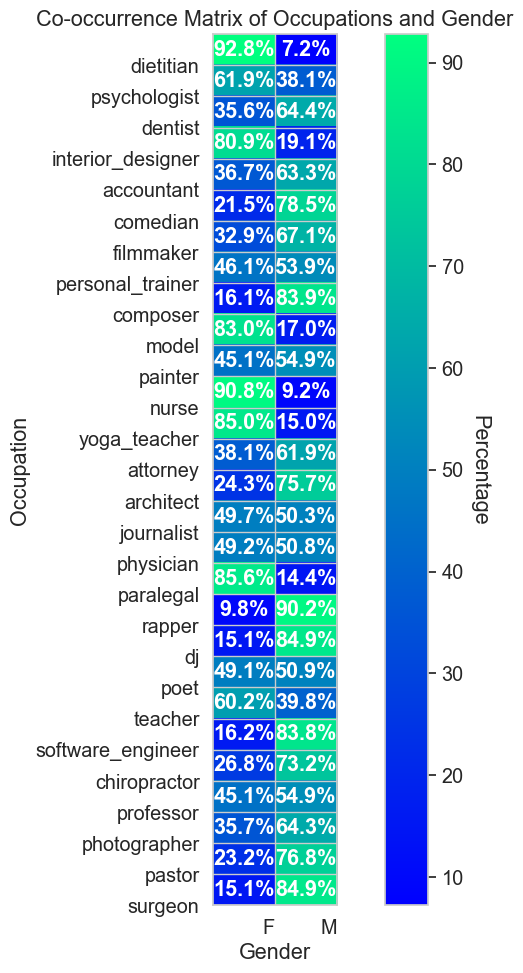

In [101]:
import numpy as np
from train import predict_gender_from_occupation

occupation_dataset = (train_labels, val_labels, test_labels)
predict_gender_from_occupation(occupation_dataset, genders)

# PART 1: Matrix decomposition

In [35]:
features = torch.cat((train_features, val_features, test_features), dim=0)

#refill the tensors:
n_train, n_val, n_test = len(train_features), len(val_features), len(test_features)
#train_features_new, val_features_new, test_features_new = features.split((n_train, n_val, n_test), dim=0)

In [36]:
from decomposition import decompose_choice

method_name = "sSVD"
num_components = 18
decomposition_method = decompose_choice(method_name, num_components)


U, W = decomposition_method.decompose(features)

num_components = U.shape[1]
print("num_components:", num_components)

num_components: 18


In [37]:
U.shape, W.shape

(torch.Size([388862, 18]), torch.Size([18, 768]))

In [38]:
U_train, U_val, U_test = U.split((n_train, n_val, n_test), dim=0)

# PART 2: Ranking concepts (Sobol)

In [106]:
from concept_removal import sobol_importance_from_sample

sobol_nb_design = 50
sampled = 10_000

pg_model.eval() 
global_importance_gender, rel_errors_all_masks = sobol_importance_from_sample(train_features, U_train.numpy(),
                                                                              W.numpy(), pg_model,
                                                                              sampled=sampled,
                                                                              num_components=num_components,
                                                                              sobol_nb_design=sobol_nb_design, 
                                                                              device=device)

100%|██████████| 10000/10000 [01:30<00:00, 110.91it/s]


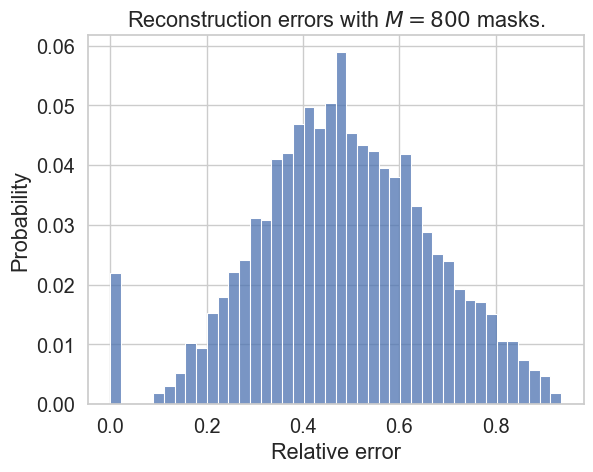

In [107]:
from visualization import plot_reconstruction_error
import matplotlib.pyplot as plt

plot_reconstruction_error(rel_errors_all_masks)

In [20]:
model.eval()
model_occ = lambda x: model.end_model(x)
global_importance_occ, _ = sobol_importance_from_sample(train_features, U_train.numpy(),
                                                        W.numpy(), model_occ,
                                                        sampled=sampled,
                                                        num_components=num_components,
                                                        sobol_nb_design=sobol_nb_design,
                                                        device=device)

100%|██████████| 10000/10000 [00:34<00:00, 288.99it/s]


In [21]:
import pickle
pickle.dump(global_importance_gender, open(f'global_importance/{modeltype}_gi_gender_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"wb"))
pickle.dump(global_importance_occ, open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"wb"))

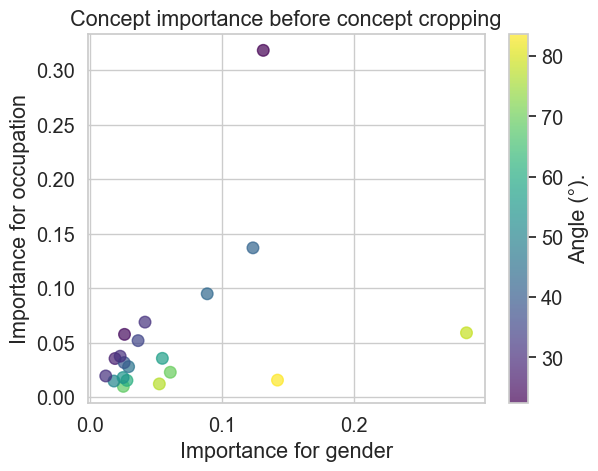

In [109]:
from visualization import plot_co_importance
plot_co_importance(global_importance_occ, global_importance_gender)

# PART 3: Remove concepts

In [10]:
import pickle
global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))


In [11]:
import numpy as np

W_gender_max = np.argmax(global_importance_gender)
f"idx={W_gender_max} concepts={global_importance_gender}"

'idx=15 concepts=[0.14178646 0.05222078 0.0249336  0.01785744 0.06052642 0.01160619\n 0.02766768 0.02475148 0.02891916 0.0186421  0.0255727  0.05451784\n 0.03610014 0.02582682 0.02251817 0.285038   0.04136292 0.08850759\n 0.1231896  0.13099605]'

In [12]:
W_occ_max = np.argmax(global_importance_occ)
f"idx={W_occ_max} concepts={global_importance_occ}"

'idx=19 concepts=[0.01558847 0.01211336 0.00987153 0.01473458 0.02279549 0.01940823\n 0.01533164 0.0179653  0.02791209 0.0353743  0.03164991 0.03555777\n 0.05181019 0.05754033 0.03750351 0.05897734 0.06878164 0.0947592\n 0.13689709 0.31800368]'

In [15]:
from concept_removal import crop_concepts, build_gender_neutral_features

nb_cpt_remov = 1
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi
W_no_gender, to_keep = crop_concepts(W.numpy(), angle, num_or_threshold=num_components-nb_cpt_remov)


train_a_no_gender = build_gender_neutral_features(U_train.numpy(), W_no_gender, to_keep)
val_a_no_gender = build_gender_neutral_features(U_val.numpy(), W_no_gender, to_keep)
test_a_no_gender = build_gender_neutral_features(U_test.numpy(), W_no_gender, to_keep)
train_a_no_gender.shape, val_a_no_gender.shape, test_a_no_gender.shape

((272203, 768), (38886, 768), (77773, 768))

# Training new model without gender information

In [18]:
retrain = False
save_name = f'no_gender/pred_g_{method_name}{num_components}_cr{nb_cpt_remov}_{modeltype}_b_{baseline}.pt'
real_dataset = train_a_no_gender, val_a_no_gender, test_a_no_gender


def to_cuda_tensor(arr):
    return torch.Tensor(arr).type(torch.FloatTensor).to(device)
real_dataset = tuple(map(to_cuda_tensor, real_dataset))
if retrain:
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=100,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     save_path_and_name=save_name)
else:
  state_dict = torch.load(save_name, map_location=torch.device(device))
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=0,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     state_dict=state_dict,
                                     save_path_and_name=save_name)

Final evaluation on the test set:

Val set: Average loss: 1.8713, Accuracy: 51940/77773 (66.784%)


In [20]:
from train import train_occupations

retrain = False
save_path = f'no_gender/pred_occ_{method_name}{num_components}_cr{nb_cpt_remov}_{modeltype}_b_{baseline}.pt'
real_dataset = train_a_no_gender, val_a_no_gender, test_a_no_gender
occupations = train_labels, val_labels, test_labels
if retrain:
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=100,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           save_path_and_name=save_path)
                                          
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_a_no_gender.shape[1]
  state_dict = torch.load(save_path, map_location=torch.device(device))
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=0,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           state_dict=state_dict,
                                           save_path_and_name=None)
                                           

Final evaluation on test set:

Val set: Average loss: 3.3035, Accuracy: 50637/77773 (65.109%)


# Visualisations

In [85]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

%matplotlib inline
sns.set()

#modeltype = "RoBERTa"
#modeltype = "DistilBERT"
modeltype = "DeBERTa"

mlp_or_lin = "mlp"
method_name = "sSVD"
num_components = 18

min_gender = 0.62679

if modeltype == "RoBERTa":
    acc_gender_baseline1 = 96.013
    acc_occ_baseline1 = 86.39
    acc_gender_baseline2 = 79.798
    acc_occ_baseline2 = 86.08
elif modeltype == "DistilBERT":
    acc_gender_baseline1 = 0.98385
    acc_occ_baseline1 = 0.8616
    acc_gender_baseline2 = 0.84357
    acc_occ_baseline2 = 0.8591
elif modeltype == "DeBERTa":
    acc_gender_baseline1 = 0.69671
    acc_occ_baseline1 = 0.8591
    acc_gender_baseline2 = 0.70569
    acc_occ_baseline2 = 0.8584

In [86]:
concept_removed = list(range(0,num_components))
save = f"plot_accuracy_{modeltype}_{method_name}{num_components}_{mlp_or_lin}"

#list created with the run_concepts_remov.py file
acc_gender = [acc_gender_baseline1] + pickle.load(open(f'figures/list/l_gender_acc_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_normal.pkl',"rb"))
acc_occ = [acc_occ_baseline1] + pickle.load(open(f'figures/list/l_occupation_acc_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_normal.pkl',"rb"))

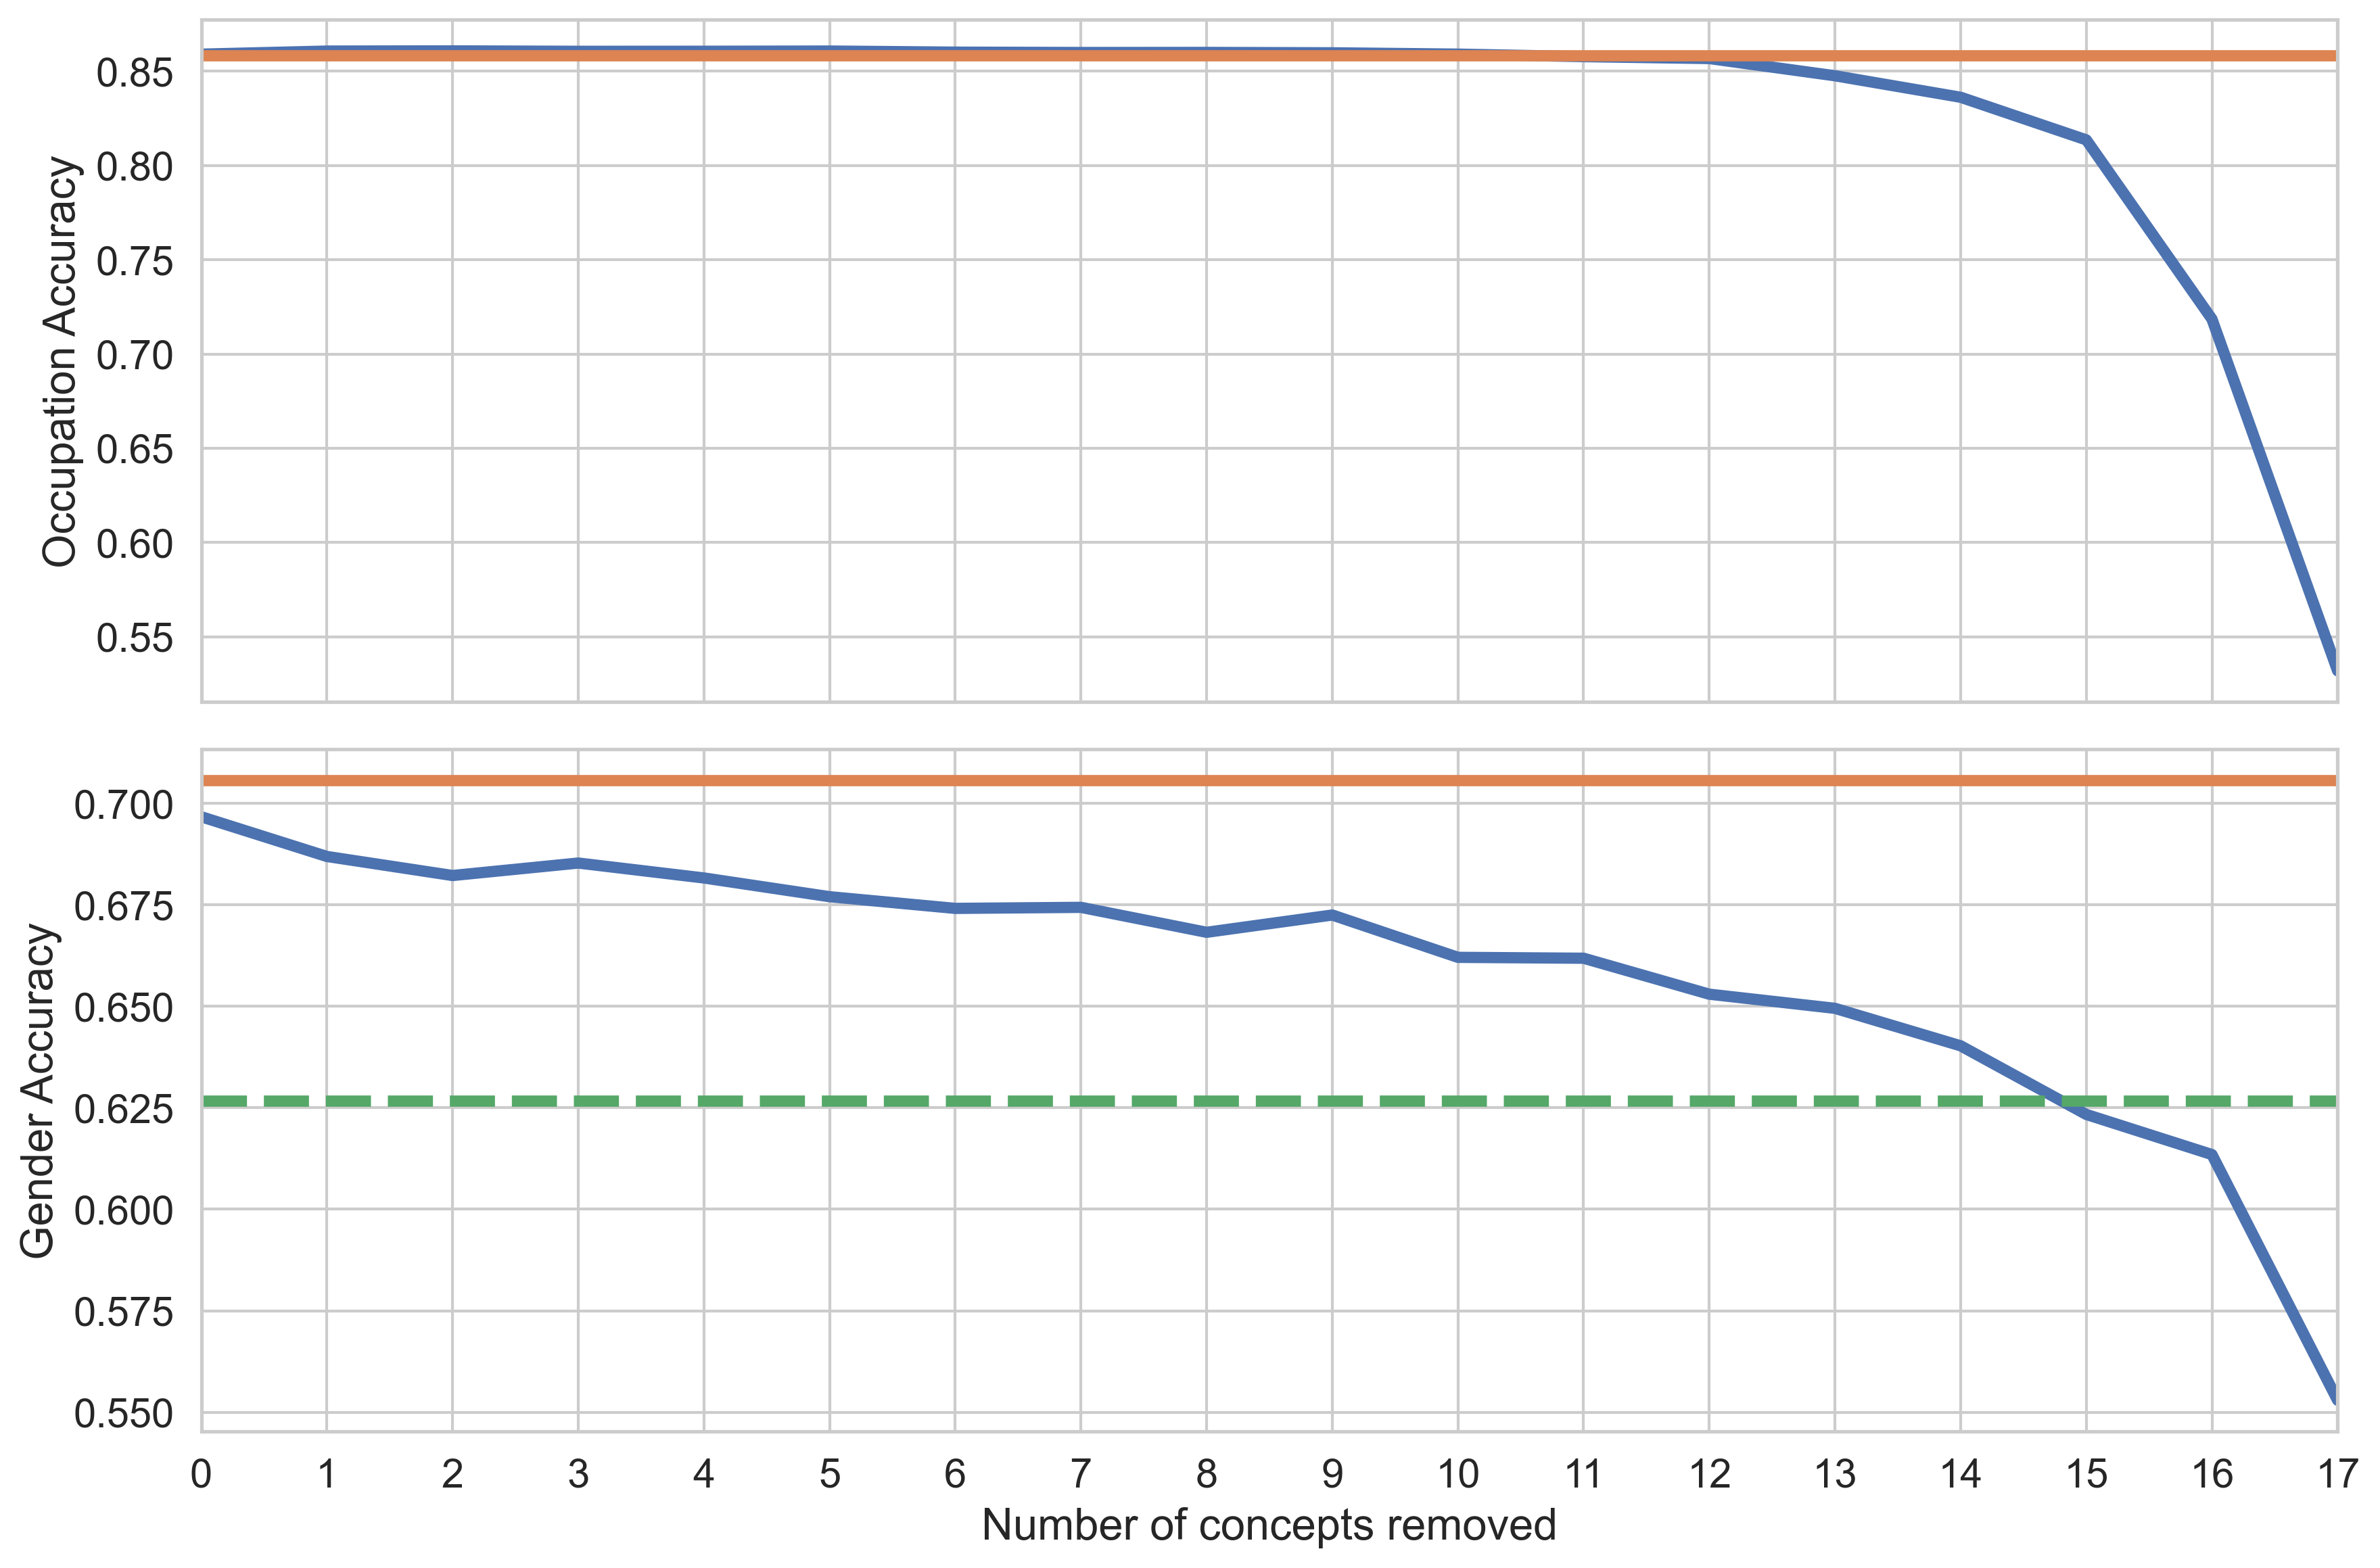

In [87]:
sns.set(font_scale=1.3)
nolegend = True

if nolegend:
  sns.set_style("whitegrid")
else:
  sns.set_style("white")

assert len(acc_gender) == len(concept_removed)
assert len(acc_occ) == len(concept_removed)

acc_gender_baseline2_line = [acc_gender_baseline2] * len(concept_removed)
acc_occ_baseline2_line = [acc_occ_baseline2] * len(concept_removed)
min_gender_line = [min_gender] * len(concept_removed)

c_removed = "Number of concepts removed"
val_acc = "Test Accuracy"
label = "Method"
metric = "Metric"
df = {
    c_removed: [],
    val_acc: [],
    label: [],
    metric: []
}

df[c_removed] += concept_removed
df[val_acc] += acc_gender
df[label] += ['Our method (Bios)'] * len(acc_gender)
df[metric] += ['Gender prediction'] * len(acc_gender)

df[c_removed] += concept_removed
df[val_acc] += acc_occ
df[label] += ['Our method (Bios)'] * len(acc_occ)
df[metric] += ['Occupation prediction'] * len(acc_occ)

df[c_removed] += concept_removed
df[val_acc] += acc_gender_baseline2_line
df[label] += ['Baseline 2 (Bios-Neutral)'] * len(acc_gender_baseline2_line)
df[metric] += ['Gender prediction'] * len(acc_gender_baseline2_line)

df[c_removed] += concept_removed
df[val_acc] += acc_occ_baseline2_line
df[label] += ['Baseline 2 (Bios-Neutral)'] * len(acc_occ_baseline2_line)
df[metric] += ['Occupation prediction'] * len(acc_occ_baseline2_line)

df[c_removed] += concept_removed
df[val_acc] += min_gender_line
df[label] += ['Gender prediction from occupation'] * len(min_gender_line)
df[metric] += ['Gender prediction'] * len(min_gender_line)

df = pd.DataFrame.from_dict(df)
isgenderocc = 'isgenderocc'
df[isgenderocc] = (df[label] == 'Gender prediction from occupation')

fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=300, sharex=True)
ax1, ax2 = axes.flatten()

ylb_num = [40, 50, 60, 70, 80, 90, 100]
ylb_num_st = [str(x) for x in ylb_num]

df_top = df[df[metric] == 'Gender prediction']
df_top_name = "Gender Accuracy"
df_top = df_top.rename({val_acc: df_top_name}, axis=1)
df_bottom = df[df[metric] == 'Occupation prediction']
df_bottom_name = "Occupation Accuracy"
df_bottom = df_bottom.rename({val_acc: df_bottom_name}, axis=1)

swap_top_bottom = True
if swap_top_bottom:
  df_top, df_bottom = df_bottom, df_top
  df_top_name, df_bottom_name = df_bottom_name, df_top_name

linewidth = 4.0

sns.lineplot(df_top,
             x=c_removed,
             y=df_top_name,
             hue=label,
             ax=ax1, linewidth=linewidth)
# ax1.set_yticks(ylb_num, ylb_num_st)

sns.lineplot(df_bottom,
             x=c_removed,
             y=df_bottom_name,
             hue=label,
             style=isgenderocc,
             ax=ax2, linewidth=linewidth)
# ax2.set_yticks(ylb_num, ylb_num_st)

handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
if not nolegend:
  handles = handles[:-3]
  labels = labels[:-3]
  color = sns.color_palette("deep")[2]
  handles[-1] = plt.Line2D([], [], color=color, linestyle='--', label='Green Line')
  ax1.legend(handles, labels, loc='best')
else:
  ax1.get_legend().remove()


plt.xlim(0, concept_removed[-1])
xlb_num = [i for i in range(num_components)]
xlb_num_st = [str(x) for x in xlb_num]
plt.xticks(xlb_num, xlb_num_st)

fig.tight_layout()
if nolegend:
  plt.savefig("figures/"+save+'_nolegend.png')
else:
  plt.savefig("figures/"+save+'.png')

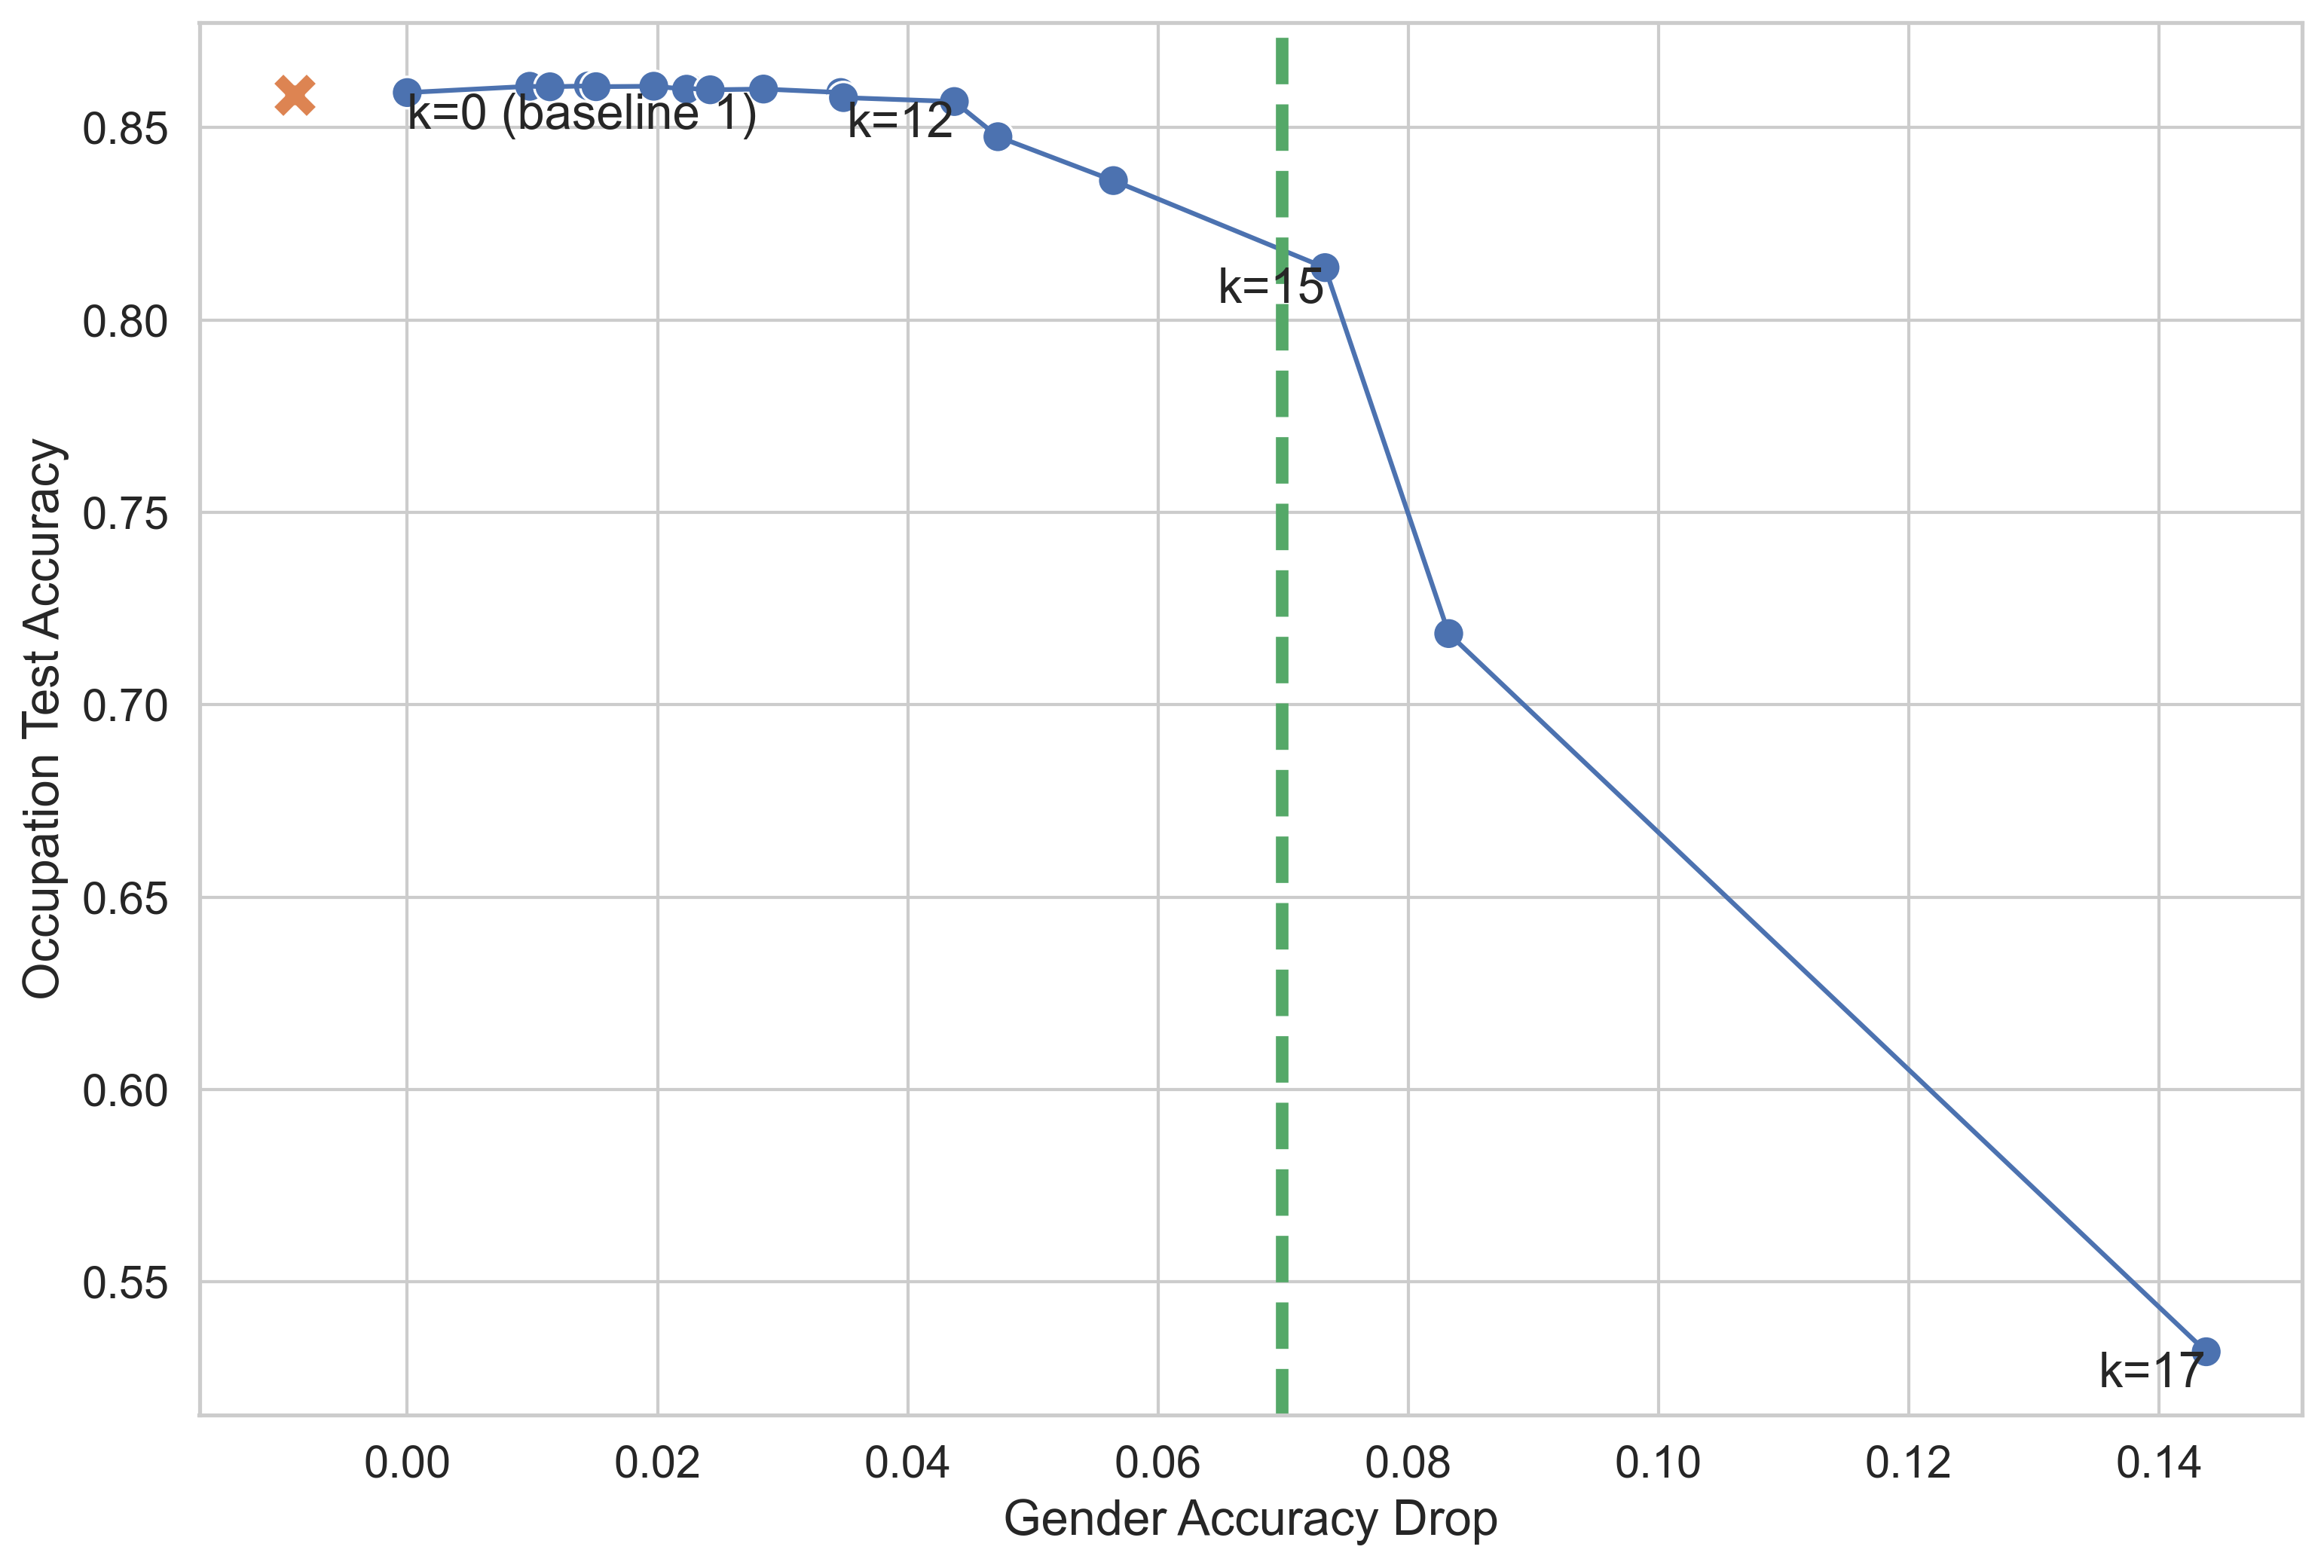

In [88]:
from matplotlib.legend_handler import HandlerBase

sns.set_palette("dark")
sns.set(font_scale=1.3)


nolegend = True
if nolegend:
  sns.set_style("whitegrid")
else:
  sns.set_style("white")


assert len(acc_gender) == len(concept_removed)
assert len(acc_occ) == len(concept_removed)

occ_of_min_gender = acc_occ[0]  # arbitrary, kind-of

drop_occ = False
drop_gender = True
green_line = True
baseline2_star = True

if drop_occ:
  max_occ = acc_occ[0]
  acc_occ = [max_occ - ao for ao in acc_occ]
  occ_of_min_gender = max_occ - occ_of_min_gender
  acc_occ_baseline2 = max_occ - acc_occ_baseline2

if drop_gender:
  max_gender = acc_gender[0]
  acc_gender = [max_gender - ag for ag in acc_gender]
  min_gender = max_gender - min_gender
  acc_gender_baseline2 = max_gender - acc_gender_baseline2

c_removed = "Number of concepts removed"
gen_acc_name = "Gender Accuracy Drop" if drop_gender else "Gender Test Accuracy"
occ_acc_name = "Occupation Accuracy Drop" if drop_occ else "Occupation Test Accuracy"
label = "Model"
df = {
    gen_acc_name: [],
    occ_acc_name: [],
    label: [],
    c_removed: []
}

df[gen_acc_name] += acc_gender
df[occ_acc_name] += acc_occ
df[label] += ['Our method (Bios)'] * len(acc_gender)
df[c_removed] += concept_removed

if not baseline2_star:
  df[gen_acc_name] += [acc_gender_baseline2]
  df[occ_acc_name] += [acc_occ_baseline2]
  df[label] += ['Baseline 2 (Bios-Neutral)']
  df[c_removed] += [0]

if not green_line:
  df[gen_acc_name] += [min_gender]
  df[occ_acc_name] += [occ_of_min_gender]
  df[label] +=['Gender prediction from occupation']
  df[c_removed] += [0]

df = pd.DataFrame.from_dict(df)


plt.figure(figsize=(12, 8), dpi=300)

ax = sns.lineplot(df,
             x=gen_acc_name,
             y=occ_acc_name,
             hue=label,
             markersize=10,
            legend=None)
sns.scatterplot(df,
             x=gen_acc_name,
             y=occ_acc_name,
             hue=label,
             s=100,
             ax=ax)

existing_handles, existing_labels = ax.get_legend_handles_labels()

if baseline2_star:
  color = sns.color_palette("deep")[1]
  sns.scatterplot(x=[acc_gender_baseline2], y=[acc_occ_baseline2], s=220, marker='X', c=[color])
  existing_handles.append(plt.Line2D([0], [0], marker='X', markersize=10, color=color, linestyle='None'))
  existing_labels.append('Baseline 2 (Bios-Neutral)')

if green_line:
  color = sns.color_palette("deep")[2]
  plt.axvline(x=min_gender, ymin=0, ymax=1, color=color, linestyle='--', linewidth=4.0)
  existing_handles.append(plt.Line2D([], [], color=color, linestyle='--', label='Green Line'))
  existing_labels.append('Gender prediction from occupation')



x_offset = 1 if not drop_gender else -1
pos_ha = 'left' if not drop_gender else 'right'
pos_va = 'top' if not drop_occ else 'bottom'
#keep = [0, 1, 12, 15, 18]
keep = [0, 12, 15, 17]
for i in range(len(concept_removed)):
  if i not in keep:
    continue
  row = df.iloc[i]
  if i == 0:
    text = 'k=0 (baseline 1)'
    x = row[gen_acc_name]
    y = row[occ_acc_name] #- 0.75
    ax.text(x, y, text, ha='left', va=pos_va)
  else:
    text = 'k=' + str(row[c_removed])
    x = row[gen_acc_name]
    y = row[occ_acc_name] #+ x_offset
    ax.text(x, y, text, ha=pos_ha, va=pos_va)


ax.legend(existing_handles, existing_labels, title='Method', loc='best')
if nolegend:
  ax.get_legend().remove()

plt.savefig("figures/"+save+f"{drop_gender}_{drop_occ}_legend{nolegend}"+'.png')

# Explanations

In [43]:
import pickle
import numpy as np

global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))

In [45]:
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi

sentences_train = []

for k in range(len(dt_X_train)):
    sentences_train.append(dt_X_train[k][0])

gender_pred_train = torch.argmax(pg_model(train_features), -1)
label_pred_train = torch.argmax(model.end_model(train_features), -1)

sentences_train = np.array(sentences_train)
train_labels = np.array(train_labels)
label_pred_train = np.array(label_pred_train)
gender_train = np.array(gender_train)
gender_pred_train = np.array(gender_pred_train)

names_g = ['F', 'M']
names_occ = ['surgeon', 'pastor', 'photographer', 'professor', 'chiropractor', 'software_engineer', 'teacher', 'poet', 'dj', 'rapper', 'paralegal', 'physician', 
              'journalist', 'architect', 'attorney', 'yoga_teacher', 'nurse', 'painter', 'model', 'composer', 'personal_trainer','filmmaker', 'comedian', 'accountant', 
              'interior_designer', 'dentist', 'psychologist', 'dietitian']


In [72]:
from explaination import occlusion_concepts, viz_concepts, print_legend, print_legend2
import random

#sentences_type = "n bios for each concept"
#sentences_type = "random sentences"
sentences_type = "selected sentences"

if modeltype == "RoBERTa":
    l_concept_id = [15, 18, 19]
    colors = {0: "rgba(255, 102, 122, ",
              1: "rgba(179, 174, 54, ", 
              2: "rgba(45, 136, 179, "}
    
elif modeltype == "DistilBERT":
    l_concept_id = [13, 16, 17] 
    colors = {0: "rgba(91, 51, 255, ",
              1: "rgba(193, 51, 255, ", 
              2: "rgba(255, 51, 164, "}

angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi
sorted_indices = sorted(range(len(angle)), key=lambda i: angle[i], reverse=False)
conceptnames = [sorted_indices.index(i) + 1 for i in l_concept_id]


if sentences_type == "n bios for each concept":
    n = 2 #number of bios for each concepts
    l_mip_ids, l_mip_sentences, l_mip_label, l_mip_predict_label, l_mip_gender, l_mip_predict_gender = [], [], [], [], [], []
    for concept_id in l_concept_id:
        mip_ids = np.argsort(U_train[:, concept_id].numpy())[::-1][:n]
        l_mip_ids.extend(mip_ids)
        l_mip_sentences.extend(sentences_train[mip_ids])
        l_mip_label.extend(train_labels[mip_ids])
        l_mip_predict_label.extend(label_pred_train[mip_ids])
        l_mip_gender.extend(gender_train[mip_ids])
        l_mip_predict_gender.extend(gender_pred_train[mip_ids])


else:
    if sentences_type == "selected sentences":
        if modeltype == "RoBERTa":
            l_mip_ids = [230484, 7029, 155554, 94984, 82706, 254362, 205272, 226245, 81814, 227333, 90373, 82798, 143102, 261617, 
                          219844, 125561, 39863, 246224, 265371, 155464, 123403, 229367]
        elif modeltype == "DistilBERT":
            l_mip_ids = [142293, 96384, 163939, 234490, 172463, 126052, 171392, 5941, 78211, 19448, 25222, 117517,
                         110738, 36185, 60128, 138762]
    
    elif sentences_type == "random sentences":
        l_mip_ids = random.sample(range(len(sentences_train)), 200)

    l_mip_sentences = sentences_train[l_mip_ids]
    l_mip_label = train_labels[l_mip_ids]
    l_mip_predict_label = label_pred_train[l_mip_ids]
    l_mip_gender = gender_train[l_mip_ids]
    l_mip_predict_gender = gender_pred_train[l_mip_ids]

In [73]:
extract_fct, l_ignore_words = "word", ["’", "'", ",", ".", "...", "..", "....", ":", "!", "?", "", " ", "(", ")"]
#extract_fct, l_ignore_words = "clause", []

print("gender importance / occupation importance")
print_legend2(colors, l_concept_id, global_importance_gender, global_importance_occ, conceptnames)
#colors = print_legend(l_concept_id, global_importance_gender, global_importance_occ, conceptnames)

i = 0
for sentence in l_mip_sentences:
  print('sentence:', l_mip_ids[i])
  print('occupation: true label:', names_occ[int(l_mip_label[i])], '; predicted label:', names_occ[int(l_mip_predict_label[i])])
  print('gender: true label:', names_g[l_mip_gender[i]], '; predicted label:', names_g[l_mip_predict_gender[i]])

  phi = occlusion_concepts(sentence, model, tokenizer, W, l_concept_id, ignore_words = l_ignore_words, extract_fct = extract_fct, device = device)
  
  phi /= np.max(np.abs(phi)) + 1e-5
  viz_concepts(sentence, phi, colors, ignore_words = l_ignore_words, extract_fct = extract_fct)
  i += 1

gender importance / occupation importance


sentence: 142293
occupation: true label: surgeon ; predicted label: surgeon
gender: true label: M ; predicted label: M


sentence: 96384
occupation: true label: surgeon ; predicted label: surgeon
gender: true label: M ; predicted label: M


sentence: 163939
occupation: true label: dentist ; predicted label: dentist
gender: true label: M ; predicted label: M


sentence: 234490
occupation: true label: physician ; predicted label: physician
gender: true label: F ; predicted label: F


sentence: 172463
occupation: true label: surgeon ; predicted label: surgeon
gender: true label: M ; predicted label: M


sentence: 126052
occupation: true label: photographer ; predicted label: photographer
gender: true label: M ; predicted label: M


sentence: 171392
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 5941
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 78211
occupation: true label: journalist ; predicted label: journalist
gender: true label: F ; predicted label: F


sentence: 19448
occupation: true label: photographer ; predicted label: photographer
gender: true label: M ; predicted label: M


sentence: 25222
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 117517
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 110738
occupation: true label: surgeon ; predicted label: attorney
gender: true label: M ; predicted label: M


sentence: 36185
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 60128
occupation: true label: composer ; predicted label: composer
gender: true label: M ; predicted label: M


sentence: 138762
occupation: true label: nurse ; predicted label: nurse
gender: true label: F ; predicted label: F
